In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
  !curl -s https://course.fast.ai/setup/colab | bash


Updating fastai...
Done.


In [ ]:
from fastai import *
from fastai.vision import*
from fastai.callbacks.hooks import*
from fastai.utils.mem import*


In [ ]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

In [ ]:
#Data ...
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03270.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f02220.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03390.png')]

In [ ]:
fnames = get_image_files(path_lbl)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04650_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08490_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_01890_P.png')]

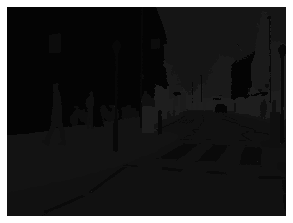

In [ ]:
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'
get_y_fn1 = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

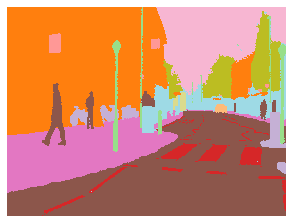

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 0MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn1, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

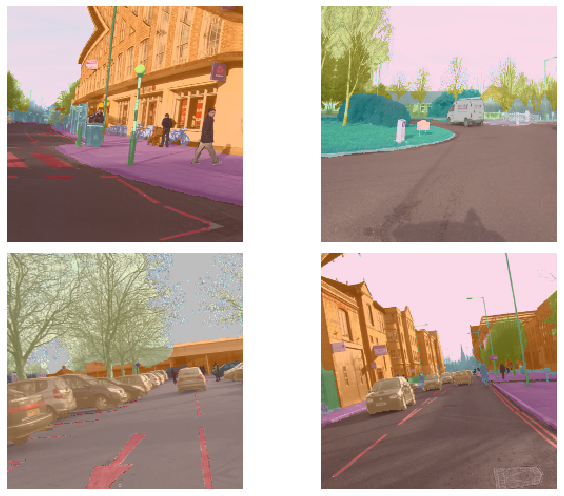

In [ ]:
data.show_batch(2, figsize=(10,7))

In [ ]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
#Build the model
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid


In [ ]:
wd=1e-2


In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 37.8MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


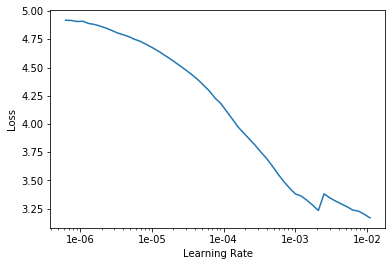

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=3e-3


In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.946811,0.760182,0.827564,26:46
1,0.726869,0.669708,0.823348,26:36
2,0.645117,0.577589,0.855207,26:39
3,0.637580,0.495400,0.866938,26:42
4,0.589971,0.470163,0.863562,26:32
5,0.575117,0.467429,0.885062,26:29
6,0.562756,0.507051,0.870980,26:42
7,0.518045,0.444681,0.873325,27:04
8,0.500079,0.452348,0.868442,27:10
9,0.414308,0.369214,0.894090,26:57


In [ ]:
learn.save('finallydone!!!')

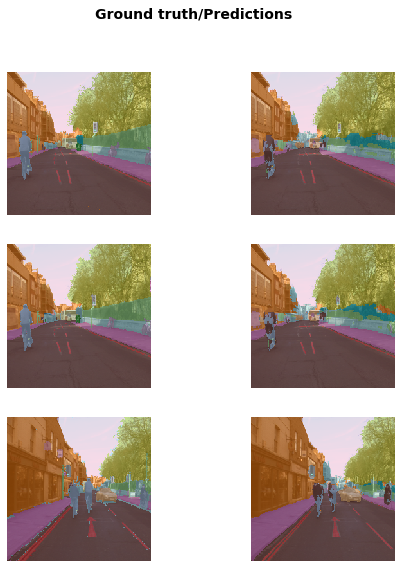

In [ ]:
learn.show_results(rows=3, figsize=(8,9))


In [ ]:
learn.load('finallydone!!!');
